In [1]:
# 📦 1. Import libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 🧼 2. Load data
df = pd.read_csv('../data/Dataset - Sheet1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [3]:
# 🧮 3. Add derived metrics
df['CTR'] = df['Clicks'] / df['Impressions'].replace(0, np.nan)
df['Fill Rate'] = df['Impressions'] / df['Requests'].replace(0, np.nan)
df['Win Rate'] = df['Bids in auction'] / df['Bid requests'].replace(0, np.nan)

In [4]:
# 🧠 4. Z-score anomaly detection
metrics = ['CTR', 'Fill Rate', 'Observed eCPM (USD)', 'Est. earnings (USD)']
z_scores = df[metrics].apply(zscore)
threshold = 3

In [5]:
# 🏷️ 5. Label anomalies
anomaly_flags = (np.abs(z_scores) > threshold)
anomaly_df = df.loc[anomaly_flags.any(axis=1), ['Date', 'Country'] + metrics].copy()

In [6]:
# Mark which metrics were flagged
for metric in metrics:
    anomaly_df[f'{metric} Anomaly'] = anomaly_flags.loc[anomaly_df.index, metric]

In [7]:
# 🗂️ 6. Reshape for anomaly summary
summary = anomaly_df.melt(
    id_vars=['Date', 'Country'],
    value_vars=[f'{m} Anomaly' for m in metrics],
    var_name='Anomaly Type',
    value_name='Is Anomaly'
)

summary = summary[summary['Is Anomaly'] == True].drop(columns='Is Anomaly')
summary['Anomaly Type'] = summary['Anomaly Type'].str.replace(' Anomaly', '')

display(summary.head())

,Date,Country,Anomaly Type
2,2021-01-16,Poland,CTR
4,2021-01-18,Ireland,CTR
5,2021-01-20,Australia,CTR
6,2021-01-21,Brazil,CTR
7,2021-01-25,US Virgin Islands,CTR


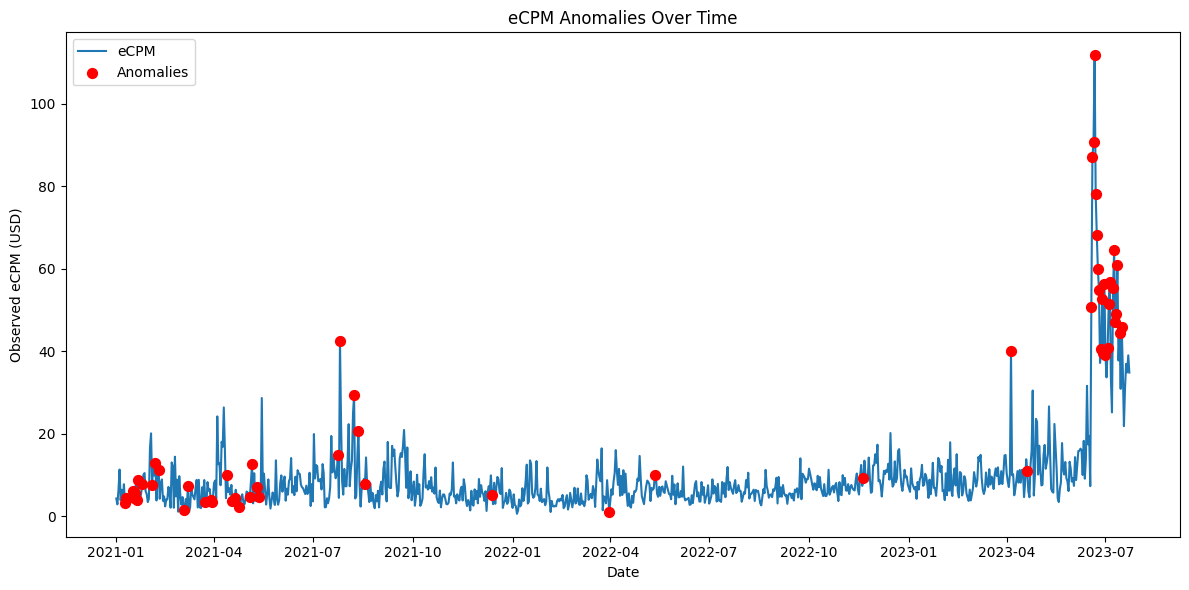

In [8]:
# 📈 7. Plot anomalies on time series
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Observed eCPM (USD)'], label='eCPM')
plt.scatter(
    anomaly_df['Date'],
    anomaly_df['Observed eCPM (USD)'],
    color='red',
    label='Anomalies',
    s=50,
    zorder=10
)
plt.title('eCPM Anomalies Over Time')
plt.xlabel('Date')
plt.ylabel('Observed eCPM (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# 💾 8. Export anomaly report
summary.to_csv('../reports/anomaly_summary.csv', index=False)
print("✅ Anomaly summary saved to reports/anomaly_summary.csv")

✅ Anomaly summary saved to reports/anomaly_summary.csv
